# Model Baseline Perfomances

The goal of this notebook is to evaluate the performance of distilBERT, BERT-base-uncased, and roBERTa-base-uncased for sequence classification on test split of the IMDb movie reviews dataset. We compare the evaluation metrics and the IG for the pretrained and finetuned versions of each model. The results of this excercise will help determine the use of integrated gradients as a valid model explainability metric for LLMs. 

# Table of Contents
1. [Setup helper functions](##setup-helper-functions)
2. [DistilBERT](##distilBERT)
3. [BERT-base-uncased](##BERT-base-uncased)
4. [roBERTa](#roBERTa)

In [1]:
!pip install -q transformers
!pip install -q datasets

In [2]:
# import required libraries
import os

import copy

import pandas as pd
import numpy as np

import torch
from torch.nn import functional as F

import matplotlib.pyplot as plt
%matplotlib inline

from transformers import BertTokenizer, BertForSequenceClassification
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import RobertaTokenizer, RobertaForSequenceClassification
from datasets import load_dataset

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

In [3]:
# check for gpu availability
device = torch.device("cuda" if torch.cuda.is_available else "cpu")
device

device(type='cuda')

## Set up helper functions

In [4]:
def convert_to_df(examples):
    """
    Converts Dataset object to dataframe.
    """
    df = pd.DataFrame(examples)
    return df

In [5]:
def sentiment_movie_score(movie_review, tokenizer, model):
    """
    Returns model prediction of movie review sentiment
    """
    inputs = tokenizer(movie_review, return_tensors = 'pt', truncation=True)
    model.to(device)
    result = model(inputs['input_ids'].to(device), inputs['attention_mask'].to(device))
    return int(torch.argmax(result.logits))

In [6]:
def eval_fn(label, pred):
    """
    Generates evaluation scores for model predictions
    """
    f1 = f1_score(label, pred)
    precision = precision_score(label, pred)
    recall = recall_score(label, pred)
    accuracy = accuracy_score(label, pred)
    
    print(f'F1 score: {f1}\nPrecison: {precision}\nRecall: {recall}\nAccuracy: {accuracy}')

In [7]:
def get_sample(dataset, sample_idx):
    """
    Selects a single sample from the dataset at the specified index
    """
    assert max(sample_idx) <= len(dataset)
    sample = dataset.shuffle(seed=0).select(sample_idx)
    review = sample['text'][0]
    label = sample['label'][0]
    return review, label

In [8]:
def get_input_output(sentence, model, tokenizer, labels):
    inputs = tokenizer(sentence, return_tensors='pt').to(device)
    model.to(device)
    outputs = model(**inputs, labels=labels, output_attentions=True, output_hidden_states=True)
    return inputs, outputs

In [9]:
def calc_integrated_gradients(inputs, model, baseline, num_steps):
  # get pretrained token embeddings
    input_embed = model.base_model.embeddings.word_embeddings(inputs['input_ids'][0])

    # input_embed = model.bert.embeddings.word_embeddings.weight
    copy_embed = copy.deepcopy(input_embed.data)

    if baseline is None:
        # create baseline
        baseline = torch.zeros_like(copy_embed)

    grads = []

    for step in range(num_steps + 1):
        input_embed.data =  baseline + step/num_steps * (copy_embed - baseline)
        outputs = model(**inputs, output_hidden_states=True, output_attentions=True)
        logits, hidden_states = outputs.logits, outputs.hidden_states
        logits = logits[0]

        # calculate the derivates of the output of BertEmbedding
        out_embed = hidden_states[0]
        g = torch.autograd.grad(logits, out_embed, grad_outputs=torch.ones_like(logits))[0]
        grads.append(g)

  # stack grads along first dimension to create a new tensor
    grads = torch.stack(grads)

  # approx integral
    grads = (grads[:-1] + grads[1:]) / 2
    avg_grad = grads.mean(0)

    integrated_grads = out_embed * avg_grad

    return integrated_grads

In [10]:
def calc_scores(integrated_grads):
    scores = torch.sqrt((integrated_grads ** 2).sum(-1))
    # normalize scores
    max_s, min_s = scores.max(1, True).values, scores.min(1, True).values
    normalized_scores = (scores - min_s) / (max_s - min_s)
    return normalized_scores[0].tolist()

In [11]:
def plot_gradients(tokens, gradients, title):
    plt.figure(figsize=(21,3))
    xvals = [ x + str(i) for i,x in enumerate(tokens)]
    colors =  [ (0,0,1, c) for c in (gradients) ]

    plt.tick_params(axis='both', which='minor', labelsize=29)
    p = plt.bar(xvals, gradients, color=colors, linewidth=1 )
    plt.title(title)
    p=plt.xticks(ticks=[i for i in range(len(tokens))], labels=tokens, fontsize=12,rotation=90)

In [12]:
def topk_tokens(tokens, gradients, k):
    # sort list of tokens and gradients 
    res = sorted(list(zip(tokens, gradients)), key = lambda x: x[1], reverse=True)
    topk_tokens, topk_grads = [], []
    for i in range(k):
        topk_tokens.append(res[i][0])
        topk_grads.append(res[i][1])
        print(res[i][0], f'Score: {res[i][1]}')
    return topk_tokens, topk_grads

## Load data 

In [13]:
# load dataset 
imdb_test = load_dataset("imdb", split='test')

print(imdb_test)

Dataset({
    features: ['text', 'label'],
    num_rows: 25000
})


In [14]:
# convert Dataset object to DataFrame
test_df = convert_to_df(imdb_test)
# make a copy of test_df
result_df = test_df.copy()
display(test_df.head())

,text,label
0,I love sci-fi and am willing to put up with a ...,0
1,"Worth the entertainment value of a rental, esp...",0
2,its a totally average film with a few semi-alr...,0
3,STAR RATING: ***** Saturday Night **** Friday ...,0
4,"First off let me say, If you haven't enjoyed a...",0


## Define IG parameters

In [15]:
review, label = get_sample(imdb_test, sample_idx=[1])
print(f'Review: {review}\nLabel: {label}')
baseline = None
num_steps = 20 # range between 20 - , depending on the complexity of the model

Review: When the Italians and Miles O'keeffe work together nothing can go wrong! As ever, Miles is great as the almost as great Ator; the most lovable barbarian of all times. Totally lives up to the first movie.
Label: 1


## DistilBert

In [16]:
distilbert = "distilbert-base-uncased"
imdb_distilbert = 'lvwerra/distilbert-imdb'

distil_tokenizer = AutoTokenizer.from_pretrained(distilbert)

distil_model = AutoModelForSequenceClassification.from_pretrained(distilbert, num_labels=2, return_dict=True)
imdb_distil_model = AutoModelForSequenceClassification.from_pretrained(imdb_distilbert, num_labels=2, return_dict=True)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.bias', 'pre_classifier.weight', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
result_df['distil_sentiment'] = test_df['text'].apply(lambda x: sentiment_movie_score(x, distil_tokenizer, distil_model))
eval_fn(np.array(result_df['label']), np.array(result_df['distil_sentiment']))

In [18]:
result_df['finetuned_distil_sentiment'] = test_df['text'].apply(lambda x: sentiment_movie_score(x, distil_tokenizer, distil_model))
eval_fn(np.array(result_df['label']), np.array(result_df['finetuned_distil_sentiment']))

F1 score: 0.6663820932155912
Precison: 0.49989993195372856
Recall: 0.99912
Accuracy: 0.4998


In [19]:
distil_inputs, distil_ouputs = get_input_output(review, distil_model, distil_tokenizer, None)
ig_distil = calc_integrated_gradients(distil_inputs, distil_model, baseline, num_steps)
scores_distil = calc_scores(ig_distil)
tokens_distil= distil_tokenizer.convert_ids_to_tokens(distil_inputs['input_ids'][0])

In [20]:
topk_tokens_distil, topk_grads_distil = topk_tokens(tokens_distil, scores_distil, 10)

totally Score: 1.0
barbarian Score: 0.9573367238044739
lives Score: 0.6258236169815063
italians Score: 0.6208071708679199
movie Score: 0.6054354906082153
[CLS] Score: 0.5703091621398926
. Score: 0.4277893602848053
##or Score: 0.354387491941452
first Score: 0.34626898169517517
##vable Score: 0.32594165205955505


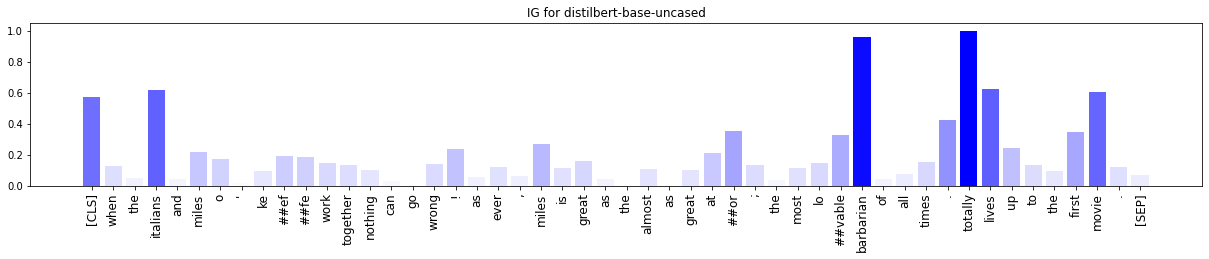

In [21]:
plot_gradients(tokens_distil, scores_distil, f"IG for {distilbert}")

In [22]:
imdb_distil_inputs, imdb_distil_ouputs = get_input_output(review, imdb_distil_model, distil_tokenizer, None)
imdb_ig_distil = calc_integrated_gradients(imdb_distil_inputs, imdb_distil_model, baseline, num_steps)
imdb_scores_distil = calc_scores(imdb_ig_distil)
imdb_tokens_distil= distil_tokenizer.convert_ids_to_tokens(imdb_distil_inputs['input_ids'][0])

In [23]:
topk_tokens_imdb_distil, topk_grads_imdb_distil = topk_tokens(imdb_tokens_distil, imdb_scores_distil, 10)

barbarian Score: 1.0
##vable Score: 0.4731347858905792
totally Score: 0.40080147981643677
italians Score: 0.3923628330230713
lives Score: 0.3577708899974823
great Score: 0.31522154808044434
[CLS] Score: 0.2508437931537628
movie Score: 0.24243929982185364
first Score: 0.17467918992042542
times Score: 0.16895554959774017


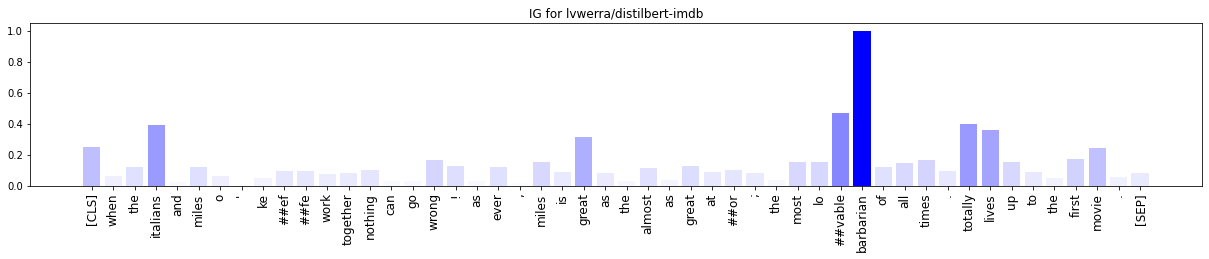

In [24]:
plot_gradients(imdb_tokens_distil, imdb_scores_distil, f"IG for {imdb_distilbert}")

## BERT-base-uncased

In [25]:
bert_base = 'bert-base-uncased'
imdb_bert_base = 'fabriceyhc/bert-base-uncased-imdb'

base_tokenizer = BertTokenizer.from_pretrained(bert_base)

base_model = BertForSequenceClassification.from_pretrained(bert_base, num_labels=2, return_dict=True)
imbd_base_model = BertForSequenceClassification.from_pretrained(imdb_bert_base, num_labels=2, return_dict=True)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [26]:
result_df['base_sentiment'] = test_df['text'].apply(lambda x: sentiment_movie_score(x, base_tokenizer, base_model))
eval_fn(np.array(result_df['label']), np.array(result_df['base_sentiment']))

F1 score: 0.008572789331639944
Precison: 0.5510204081632653
Recall: 0.00432
Accuracy: 0.5004


In [27]:
result_df['imdb_base_sentiment'] = test_df['text'].apply(lambda x: sentiment_movie_score(x, base_tokenizer, imbd_base_model))
eval_fn(np.array(result_df['label']), np.array(result_df['imdb_base_sentiment']))

F1 score: 0.9307631160572336
Precison: 0.9248815165876777
Recall: 0.93672
Accuracy: 0.93032


In [28]:
base_inputs, base_outputs = get_input_output(review, base_model, base_tokenizer, None)
ig_base = calc_integrated_gradients(base_inputs, base_model, baseline, num_steps)
scores_base = calc_scores(ig_base)
tokens_base = base_tokenizer.convert_ids_to_tokens(base_inputs['input_ids'][0])

In [29]:
topk_tokens_base, topk_grads_base = topk_tokens(tokens_base, scores_base, 10)

[CLS] Score: 1.0
barbarian Score: 0.6340150833129883
totally Score: 0.6056150197982788
lives Score: 0.435956209897995
italians Score: 0.4343216121196747
##vable Score: 0.385654091835022
great Score: 0.37572988867759705
movie Score: 0.3519125282764435
##ef Score: 0.2480069100856781
ever Score: 0.2186013013124466


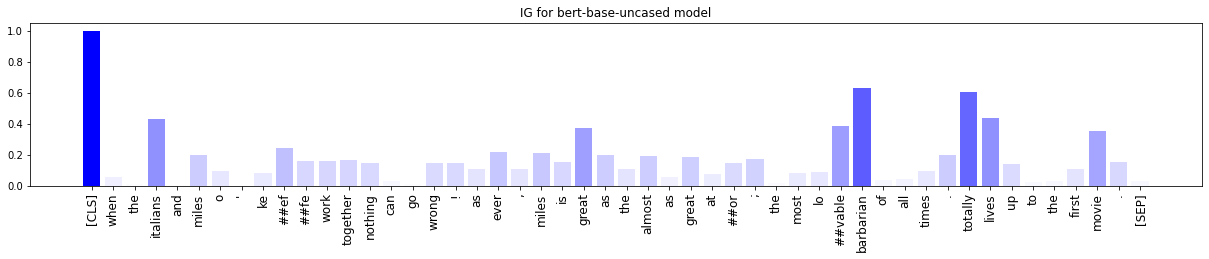

In [30]:
plot_gradients(tokens_base, scores_base, f'IG for {bert_base} model' )

In [31]:
imdb_base_inputs, imdb_base_outputs = get_input_output(review, imbd_base_model, base_tokenizer, None)
imdb_ig_base = calc_integrated_gradients(imdb_base_inputs, imbd_base_model, baseline, num_steps)
imdb_scores_base = calc_scores(imdb_ig_base)
imdb_tokens_base = base_tokenizer.convert_ids_to_tokens(imdb_base_inputs['input_ids'][0])

In [32]:
imdb_topk_tokens_base, imdb_topk_grads_base = topk_tokens(imdb_tokens_base, imdb_scores_base, 10)

barbarian Score: 1.0
##vable Score: 0.8384172320365906
first Score: 0.6130409836769104
lives Score: 0.60838383436203
##or Score: 0.5875440239906311
movie Score: 0.5108721852302551
at Score: 0.4932708442211151
totally Score: 0.48479634523391724
italians Score: 0.38500872254371643
great Score: 0.3837522268295288


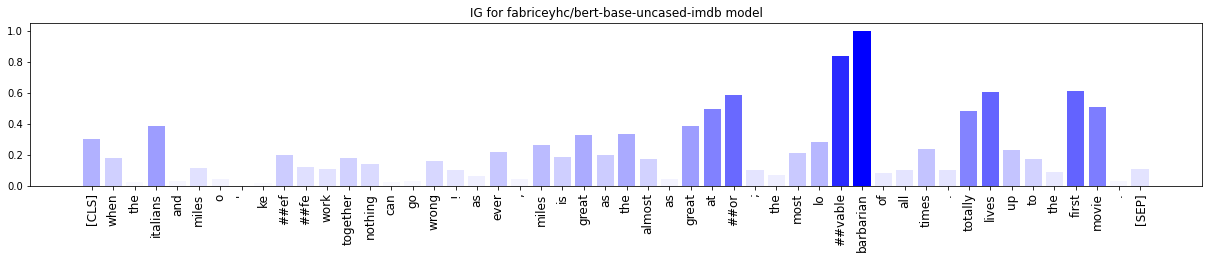

In [33]:
plot_gradients(imdb_tokens_base, imdb_scores_base, f'IG for {imdb_bert_base} model' )

## roBERTa

In [34]:
roberta = 'roberta-base'
imdb_roberta = 'aychang/roberta-base-imdb'

roberta_tokenizer = RobertaTokenizer.from_pretrained(roberta)

roberta_model = RobertaForSequenceClassification.from_pretrained(roberta)
imdb_roberta_model = RobertaForSequenceClassification.from_pretrained(imdb_roberta)

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.out_proj.weight', 'classifier.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [35]:
result_df['roberta_sentiment'] = test_df['text'].apply(lambda x: sentiment_movie_score(x, roberta_tokenizer, roberta_model))
eval_fn(np.array(result_df['label']), np.array(result_df['roberta_sentiment']))

F1 score: 0.0
Precison: 0.0
Recall: 0.0
Accuracy: 0.5


/share/pkg.7/python3/3.10.5/install/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1327: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [36]:
roberta_inputs, roberta_ouputs = get_input_output(review, roberta_model, roberta_tokenizer, None)
ig_roberta = calc_integrated_gradients(roberta_inputs, roberta_model, baseline, num_steps)
scores_roberta = calc_scores(ig_roberta)
tokens_roberta = roberta_tokenizer.convert_ids_to_tokens(roberta_inputs['input_ids'][0])

In [37]:
topk_tokens_roberta, topk_grads_roberta = topk_tokens(tokens_roberta, scores_roberta, 10)

Ġbarb Score: 1.0
ĠItalians Score: 0.8410228490829468
arian Score: 0.3625156581401825
ffe Score: 0.35991954803466797
ĠTotally Score: 0.3500981032848358
Ġmovie Score: 0.3081413805484772
ĠMiles Score: 0.2881219983100891
ovable Score: 0.28459832072257996
ĠMiles Score: 0.2814558446407318
! Score: 0.2607932984828949


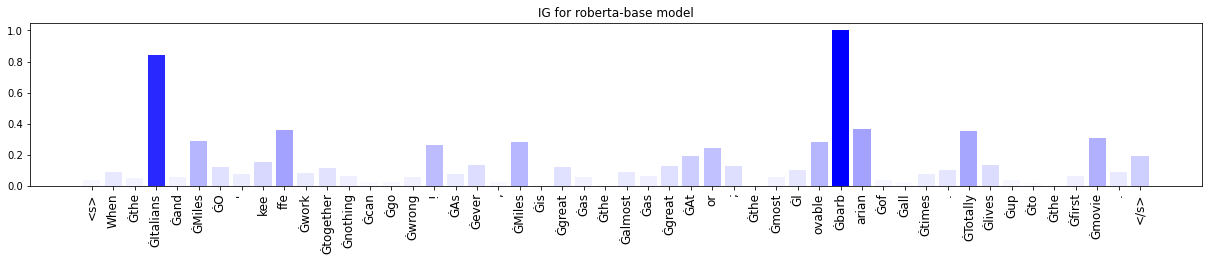

In [38]:
plot_gradients(tokens_roberta, scores_roberta, f'IG for {roberta} model')

In [39]:
result_df['imdb_roberta_sentiment'] = test_df['text'].apply(lambda x: sentiment_movie_score(x, roberta_tokenizer, imdb_roberta_model))
eval_fn(np.array(result_df['label']), np.array(result_df['imdb_roberta_sentiment']))

F1 score: 0.9473101703624649
Precison: 0.9362450191421204
Recall: 0.95864
Accuracy: 0.94668


In [40]:
imdb_roberta_inputs, imdb_roberta_ouputs = get_input_output(review, imdb_roberta_model, roberta_tokenizer, None)
imdb_ig_roberta = calc_integrated_gradients(imdb_roberta_inputs, imdb_roberta_model, baseline, num_steps)
imdb_scores_roberta = calc_scores(imdb_ig_roberta)
imdb_tokens_roberta = roberta_tokenizer.convert_ids_to_tokens(imdb_roberta_inputs['input_ids'][0])

In [41]:
imdb_topk_tokens_roberta, imbd_topk_grads_roberta = topk_tokens(imdb_tokens_roberta, imdb_scores_roberta, 10)

ĠTotally Score: 1.0
Ġgreat Score: 0.8312911987304688
Ġlives Score: 0.7278521656990051
Ġbarb Score: 0.5316978096961975
Ġfirst Score: 0.509239673614502
ĠMiles Score: 0.47796788811683655
Ġmovie Score: 0.43243804574012756
ĠItalians Score: 0.33490681648254395
ffe Score: 0.3141946792602539
ĠMiles Score: 0.3088281452655792


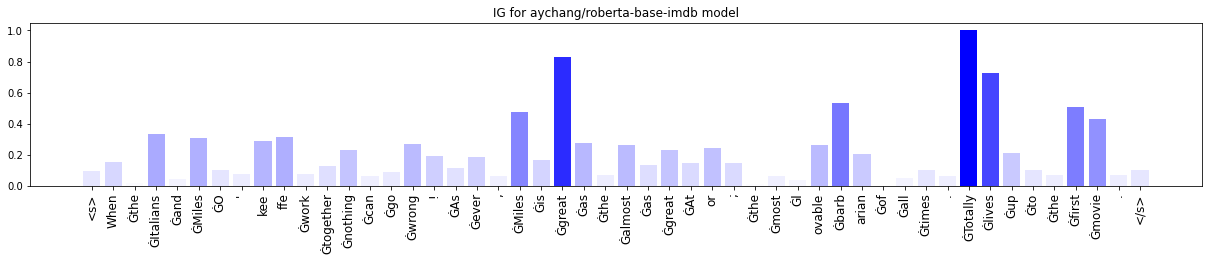

In [42]:
plot_gradients(imdb_tokens_roberta, imdb_scores_roberta, f'IG for {imdb_roberta} model' )

In [43]:
# save results to csv file

result_df.to_csv('result.csv')